# NAME: HOSLEY, BRANDON

## OPER 785 Homework 4

In this assignment, you will be asked to construct an ANN to predict time-series data given past observed values.

**Instructions:** You have data from a time series, and you must construct a neural network to predict future values based on additional instructions below.

**Data:**

Mount your Colab drive to make data available for use.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Setup

Import a few common modules, ensure MatplotLib plots figures inline and prepare a function to save the figures. We also check that Python 3.5 or later is installed (although Python 2.x may work, it is deprecated so we strongly recommend you use Python 3 instead), as well as Scikit-Learn ≥0.20 and TensorFlow ≥2.0.

In [ ]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
    IS_COLAB = True
except Exception:
    IS_COLAB = False

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
#assert tf.__version__ >= "2.0"

if not tf.config.list_physical_devices('GPU'):
    print("No GPU was detected. CNNs can be very slow without a GPU.")
    if IS_COLAB:
        print("Go to Runtime > Change runtime and select a GPU hardware accelerator.")

# Common imports
import numpy as np
import os
import pandas as pd

# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "hw4"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.
No GPU was detected. CNNs can be very slow without a GPU.
Go to Runtime > Change runtime and select a GPU hardware accelerator.


*TO DO:* Load other packages you feel necessary to solve the problem at hand.

In [ ]:
from sklearn.model_selection import train_test_split

**Some plotting code that will be useful later**

You can adapt use this code or adapt it as you require. Alternately, you may code your own plotting algorithms as you see fit to meet the requirements in the sections below.

In [ ]:
def plot_series(series, y=None, y_pred=None, x_label="$t$", y_label="$x(t)$"):
    plt.plot(series, ".-")
    if y is not None:
        plt.plot(np.shape(series)[0], y, "bx", markersize=10) # You will have to change "time_steps" to comply with your variable naming
    if y_pred is not None:
        plt.plot(np.shape(series)[0], y_pred, "ro") # You will have to change "time_steps" to comply with your variable naming
    plt.grid(True)
    if x_label:
        plt.xlabel(x_label, fontsize=16)
    if y_label:
        plt.ylabel(y_label, fontsize=16, rotation=0)
    plt.hlines(0, 0, 100, linewidth=1)
    plt.axis([0, np.shape(series)[0] + 1, -1, 1]) # You will have to change "time_steps" to comply with your variable naming

def plot_learning_curves(loss, val_loss):
    plt.plot(np.arange(len(loss)) + 0.5, loss, "b.-", label="Training loss")
    plt.plot(np.arange(len(val_loss)) + 1, val_loss, "r.-", label="Validation loss")
    plt.gca().xaxis.set_major_locator(mpl.ticker.MaxNLocator(integer=True))
    plt.axis([1, 20, 0, 0.05])
    plt.legend(fontsize=14)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.grid(True)

def plot_ANN_history(df):
    pd.DataFrame(history.history).plot(figsize=(8,5))
    plt.grid(True)
    plt.gca().set_ylim(0,1) # sets verticle range to [0,1]
    plt.show



## Load data

Data is located in the file "OPER 785 hw4 data.csv"

**Format:** The data is 10000 sections (samples) of the time series. Each section (line) consists of 51 observations.

*To Do:* Load the data from the file. Keep the data in a variable you can refer to later (in other sections). Sectioning the data file will occur in each part of the assignment as needed for prediction requirements.

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/OPER 785 hw4 data.csv', header=None)
df.head()


,0,1,2,3,4,5,6,7,8,9,...,41,42,43,44,45,46,47,48,49,50
0,0.013951,-0.135745,-0.192038,-0.198360,-0.188520,-0.185554,-0.219103,-0.265452,-0.363647,-0.502172,...,0.745896,0.692483,0.493563,0.287142,0.230265,-0.031569,-0.079382,-0.098199,-0.183484,-0.125930
1,0.082911,-0.084495,-0.470652,-0.570966,-0.599185,-0.493097,-0.439945,-0.192659,-0.012055,0.157276,...,-0.079118,0.315830,0.458525,0.695697,0.656184,0.490466,0.404144,0.096235,-0.132394,-0.304930
2,0.000707,0.271395,0.512827,0.661378,0.709255,0.662822,0.625877,0.411924,0.042748,-0.280843,...,0.339574,0.387236,0.409738,0.378475,0.217450,0.043857,-0.222421,-0.475873,-0.660221,-0.701428
3,0.659863,0.470764,0.103571,-0.065172,-0.308280,-0.390351,-0.345684,-0.302929,-0.191860,-0.263193,...,0.258120,-0.026560,-0.300560,-0.354342,-0.331767,-0.337039,-0.204367,-0.254055,-0.247731,-0.371692
4,0.080248,0.121527,0.294696,0.575162,0.735475,0.706538,0.716074,0.535590,0.360941,0.007944,...,-0.491460,-0.674930,-0.694965,-0.629618,-0.512962,-0.358641,-0.251280,-0.129526,-0.009594,-0.004331


*Optional
To Do:*

Look at your data in whatever way you may need or deem appropriate.

In [ ]:
np.shape(df)


(10000, 51)

## Part 1

For part 1, you will be predicting the next (single) value in the time series.

*To Do:*

1) section the data into the input and target (x and y),

2) section the data into training, testing, and validation sets (70%, 20%, 10%)

In [ ]:
X,y = df.iloc[:,:-1], df.iloc[:,-1]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.125, random_state=42)

*Optional To Do:*

Explore your time series

Saving figure time_series_plot


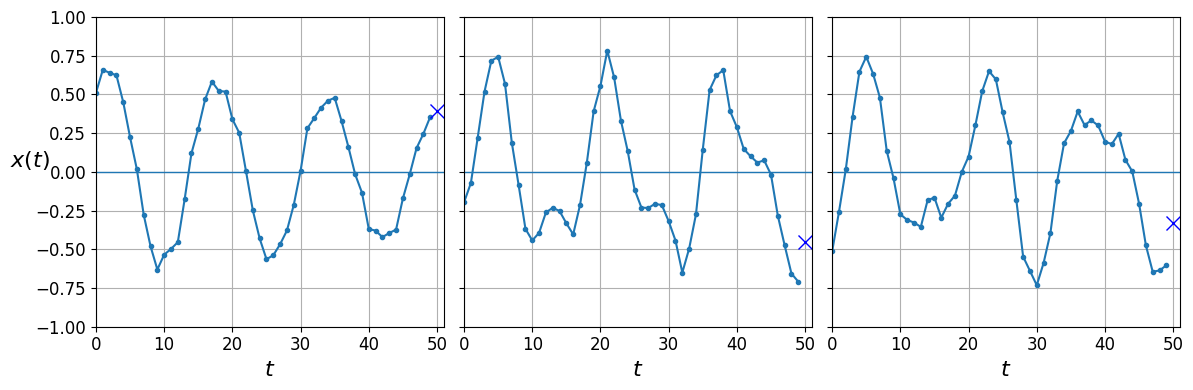

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=3, sharey=True, figsize=(12, 4))
for col in range(3):
    plt.sca(axes[col])
    plot_series(X_train.iloc[col,:], y_train.iloc[col],
                y_label=("$x(t)$" if col==0 else None))
save_fig("time_series_plot")
plt.show()


*To Do:* Compute the mean square error of the validation set using a naive forecast.

In [ ]:
np.sum(X_val.iloc[:,-1]-y_val)**2 / len(X_val.iloc[:,-1])

0.02514840278623719

*To Do:* Construct a MLP model to make a linear prediction. Then calculate the mean square error of the validation set using your MLP. Discuss hyperparameter choices to include early stopping conditions selected. Experimentation is not required. However, you should explain your reasoning for hyperparameter settings.

In [ ]:
ANNmodel = tf.keras.Sequential()
ANNmodel.add(tf.keras.layers.Input(
    shape=(len(X_val.iloc[1,:]),)       # Input the full series values.
))
ANNmodel.add(tf.keras.layers.Dense(     # Fully connected layers to keep with the simple perceptron style.
    len(X_val.iloc[1,:])                # Same width as the input to replicate the previous HW problem.
))
ANNmodel.add(tf.keras.layers.Dense(
    1                                   # Linear Output
))

ANNmodel.compile(loss="mse", optimizer="adam")
history = ANNmodel.fit(X_train, y_train, epochs=20,
                       callbacks=[tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)],
                       validation_data=(X_val, y_val))

# 20 epochs was chosen as an arbitrary length of training,
# anticipating that it would occur fast enough to run a new compile
# if the 20 epochs turn out to be insufficient.

# Early-stopping is performed by a call back in which failing to improve
# for 3 epochs would end training, any larger seems like it won't
# provide much benefit, and shorter seems too myopic.

Epoch 1/20
219/219 [==============================] - 2s 4ms/step - loss: 0.0252 - val_loss: 0.0096
Epoch 2/20
219/219 [==============================] - 1s 3ms/step - loss: 0.0083 - val_loss: 0.0074
Epoch 3/20
219/219 [==============================] - 1s 3ms/step - loss: 0.0073 - val_loss: 0.0066
Epoch 4/20
219/219 [==============================] - 1s 5ms/step - loss: 0.0069 - val_loss: 0.0073
Epoch 5/20
219/219 [==============================] - 2s 7ms/step - loss: 0.0068 - val_loss: 0.0065
Epoch 6/20
219/219 [==============================] - 2s 7ms/step - loss: 0.0069 - val_loss: 0.0066
Epoch 7/20
219/219 [==============================] - 1s 7ms/step - loss: 0.0070 - val_loss: 0.0065
Epoch 8/20
219/219 [==============================] - 1s 5ms/step - loss: 0.0068 - val_loss: 0.0065


*To Do:* Plot your losses over the training epochs and discuss model fitness, overfit, and mitigation you may have used for the latter.

You may use the predefined functions "plot_learning_curves" or "plot_ANN_history" or code you have developed for the purpose as you please.

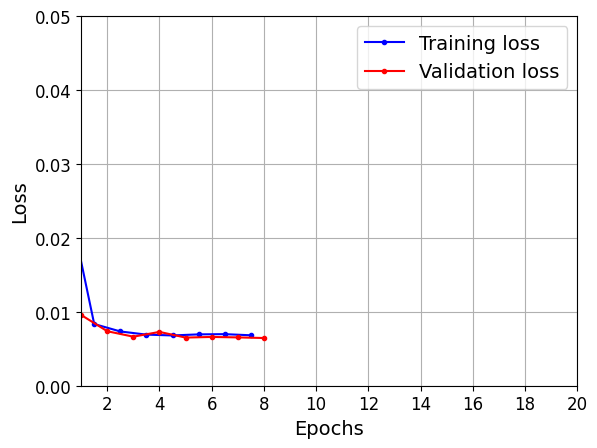

In [ ]:
plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()


*To Do:* Plot the first time series sample in your data set an include the truth value and the predicted value from your MLP model.

The predefined methods "plot_series" may be used for your convenience, or you may use your own code.

32/32 [==============================] - 0s 3ms/step
Saving figure time_series_plot


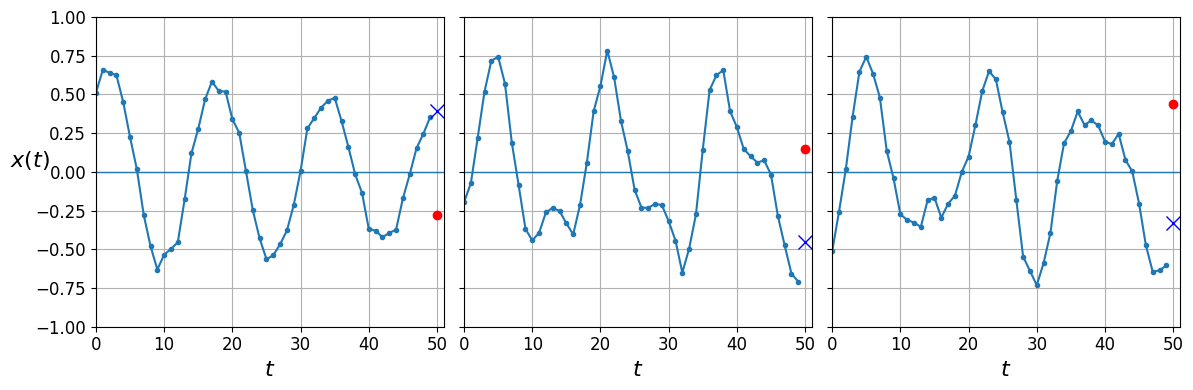

In [ ]:
y_val_preds = ANNmodel.predict(X_val)

fig, axes = plt.subplots(nrows=1, ncols=3, sharey=True, figsize=(12, 4))
for col in range(3):
    plt.sca(axes[col])
    plot_series(X_train.iloc[col,:], y_train.iloc[col],
                y_label=("$x(t)$" if col==0 else None),
                y_pred=y_val_preds[col])
save_fig("time_series_plot")
plt.show()

In [ ]:
ANNmodel.evaluate(X_val, y_val)

32/32 [==============================] - 0s 3ms/step - loss: 0.0065


0.00645331060513854

*To Do:* Construct a Deep Recurrent Network to make predictions for the time series.

In [ ]:
np.random.seed(42)
tf.random.set_seed(42)

RNNmodel = keras.models.Sequential([
    keras.layers.SimpleRNN(len(X_val.iloc[1,:]), return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(len(X_val.iloc[1,:]), return_sequences=True),
    keras.layers.SimpleRNN(1) # this layer has one unit -> the hidden state is just one number
])

RNNmodel.compile(loss="mse", optimizer="adam")
history = RNNmodel.fit(X_train, y_train, epochs=40,
                    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)],
                    validation_data=(X_val, y_val))

Epoch 1/40
219/219 [==============================] - 20s 52ms/step - loss: 0.0371 - val_loss: 0.0114
Epoch 2/40
219/219 [==============================] - 7s 34ms/step - loss: 0.0089 - val_loss: 0.0071
Epoch 3/40
219/219 [==============================] - 10s 44ms/step - loss: 0.0079 - val_loss: 0.0065
Epoch 4/40
219/219 [==============================] - 9s 41ms/step - loss: 0.0069 - val_loss: 0.0071
Epoch 5/40
219/219 [==============================] - 8s 35ms/step - loss: 0.0069 - val_loss: 0.0083
Epoch 6/40
219/219 [==============================] - 10s 44ms/step - loss: 0.0066 - val_loss: 0.0066


*To Do:* Discuss your RNN. Points you must address: NN depth, width, hyperparameter settings, early stopping (if applicable). Your reasoning for each setting is important.

The early stopping parameter is set to 3 for the same reasons as above, though in neither case did this occur as the validation set loss happened to be cyclicly increasing and decreasing.

The depth and width selected were based upon the previous models trained in this assignment. The MLP had inferior, but suprisingly close performance to the simple RNN. The thought process was to combine the parameters of both to see how the performance compared.


### Part 1 Analysis

*To Do:* Compare and discuss the results from you Deep RNN with the naive and linear forecast models.

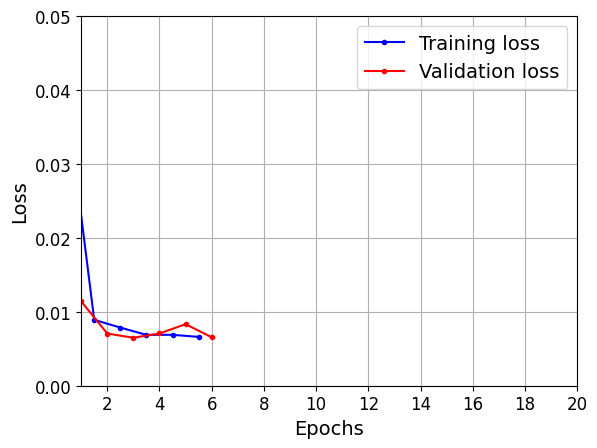

32/32 [==============================] - 0s 9ms/step - loss: 0.0066
MSE value: 0.00655345106497407


In [ ]:
plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

print(f'MSE value: {RNNmodel.evaluate(X_val, y_val)}')

32/32 [==============================] - 1s 11ms/step


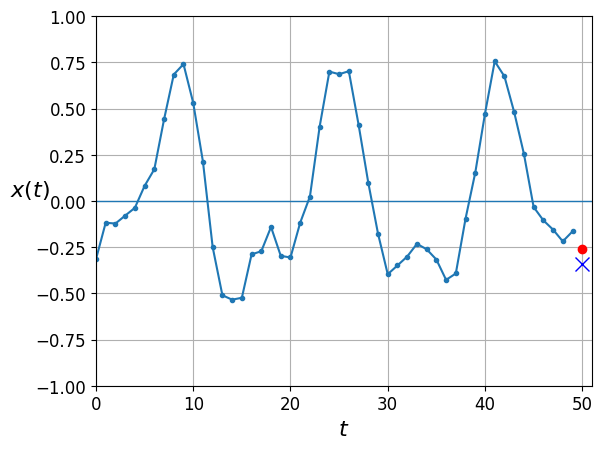

In [ ]:
y_rval_pred = RNNmodel.predict(X_val)
plot_series(X_val.iloc[0, :], y_val.iloc[0], y_rval_pred[0])
plt.show()

This model does perform significantly better than the naive model, but only marginal increase over the MLP network. Mostly, this is probably due to the limited amount of improvement that can occur over that error.

While the improvement was marginal, the training stopped early with far fewer Epochs needed; though the time needed to complete each epoch is longer, resulting in a net increase in total training time.

## Part 2: Forecasting Multiple Steps Ahead

Going back to the original data you loaded from the file "OPER 785 hw4.csv," we are going to construct a recurrent neural network to predict 5 steps ahead.

*To Do:*

1) section the data into the input and target (x and y). Your y will consist of the last 5 observations in each series.

2) section the data into training, testing, and validation sets (70%, 20%, 10%)

In [ ]:
n_steps_out = 5
n_prev_steps = 1

X = df.iloc[:,:df.shape[1] - n_steps_out]
y = np.empty(X.shape + (n_steps_out,))

for n in range(n_steps_out):
    y[:,:,n] = df.iloc[:,n+1:X.shape[1]+n+1]

X = X.to_numpy().reshape((X.shape[0], X.shape[1], 1))

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.125, random_state=42)

print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)

(7000, 46, 1) (7000, 46, 5)
(1000, 46, 1) (1000, 46, 5)


*To Do:*

Construct a Deep Recurrent Network capable of predicting multiple time steps ahead.

In [117]:
width = 30

RNNmodel = keras.models.Sequential([
    keras.layers.SimpleRNN(width, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(width, return_sequences=True),
    keras.layers.SimpleRNN(width, return_sequences=True),
    keras.layers.Dense(n_steps_out)
])

# Compile the model
RNNmodel.compile(optimizer='adam', loss='mse')
history = RNNmodel.fit(X_train, y_train, epochs=20,
                    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)],
                    validation_data=(X_val, y_val))

Epoch 1/20
219/219 [==============================] - 33s 108ms/step - loss: 0.0547 - val_loss: 0.0371
Epoch 2/20
219/219 [==============================] - 19s 88ms/step - loss: 0.0327 - val_loss: 0.0309
Epoch 3/20
219/219 [==============================] - 10s 47ms/step - loss: 0.0304 - val_loss: 0.0314
Epoch 4/20
219/219 [==============================] - 8s 38ms/step - loss: 0.0288 - val_loss: 0.0285
Epoch 5/20
219/219 [==============================] - 9s 41ms/step - loss: 0.0276 - val_loss: 0.0278
Epoch 6/20
219/219 [==============================] - 8s 38ms/step - loss: 0.0267 - val_loss: 0.0266
Epoch 7/20
219/219 [==============================] - 7s 30ms/step - loss: 0.0257 - val_loss: 0.0256
Epoch 8/20
219/219 [==============================] - 9s 40ms/step - loss: 0.0249 - val_loss: 0.0249
Epoch 9/20
219/219 [==============================] - 7s 30ms/step - loss: 0.0242 - val_loss: 0.0239
Epoch 10/20
219/219 [==============================] - 10s 47ms/step - loss: 0.0232 - v

In [ ]:
X_val.shape, y_val.shape, RNNmodel.predict(X_val).shape

32/32 [==============================] - 1s 16ms/step


((1000, 46, 1), (1000, 46, 5), (1000, 46, 5))

32/32 [==============================] - 1s 27ms/step
Saving figure forecast_ahead_plot


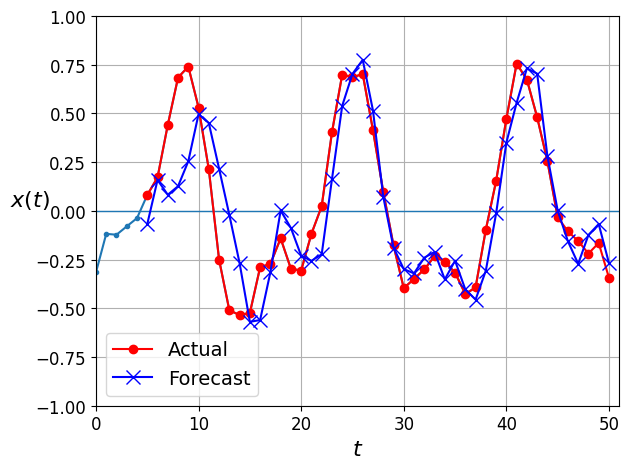

In [119]:
def plot_multiple_forecasts(X, Y, Y_pred):
    n_steps = Y.shape[2]
    length = X.shape[1]
    plot_series(X[0, :, 0])
    plt.plot(np.arange(n_steps, n_steps + length), Y[0, :, -1], "ro-", label="Actual")
    plt.plot(np.arange(n_steps, n_steps + length), Y_pred[0, :, -1], "bx-", label="Forecast", markersize=10)
    plt.axis([0, n_steps + length, -1, 1])
    plt.legend(fontsize=14)

y_val_preds = RNNmodel.predict(X_val)

plot_multiple_forecasts(X_val, y_val, y_val_preds)
save_fig("forecast_ahead_plot")
plt.show()

*To Do:* Calculate the MSE for your Deep RNN. Discuss the difference between the MSE in predicting 10 values vs. the MSE in part 1, where only a single prediction was made. What makes them different?

In [120]:
np.mean(keras.metrics.mean_squared_error(y_val, y_val_preds))

0.019303426

In the case of a single prediction, there is only one residual per time series with which to calculate the error. For the forecasting models, there are at minimum a number of residuals equal to the forecasting length. In the case of the example problem from class this was 10. In the case of this problem it may have been as little as 5. However, with the implementation that I have made it has residuals equal to the time series length minus the forecast distance. In this way it operates fairly similarly to a goodness of fit test.